## EA run comparison

Read all experiment data:

In [54]:
import os
import pandas as pd
import glob
import re

run_directory_prefix = "../models/NarxModelSearch/runs/"
file_name_pattern = "*Runs.csv"
columns = ["datetime", "iteration", "island", "cvMseMean", "cvMseStd", "cvSmapeMean", "cvSmapeStd", "holdoutRmse", "holdoutSmape", "holdoutMape", "holdoutMse", "holdoutIoa", "full_parameters"]

experiment_directories = ["18CellularAutomata3DGrid3x3x3_5AgentsO3_1994-2018_16_stations_calendar", 
                          "18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-2018_16_stations_calendar", 
                          "18Islands20AgentsO3_1994-2018_16_stations_calendar", 
                          "18Islands5AgentsO3_1994-2018_16_stations_calendar",
                          "18CellularAutomata3DGrid3x3x3_5AgentsPM10_1994-2018_16_stations_calendar",
                          "18Islands20AgentsPM10_1994-2018_16_stations_calendar",
                          "18Islands5AgentsPM10_1994-2018_16_stations_calendar"
                         ]

run_directories = []
for experiment_directory in experiment_directories:
    new_run_directory = run_directory_prefix + experiment_directory + "/"
#     print("new_run_directory:", new_run_directory)
    run_directories.append(new_run_directory)

worker_directories = ["local", "TX2"]

# print(run_directories)

dirs_list = []
for run_directory in run_directories:
    dirs_list.append(os.listdir(run_directory))
#     print("dirs:", os.listdir(run_directory))
    
for dirs in dirs_list:
    for item in dirs:
        if item not in worker_directories:
            sub_items = os.listdir(run_directories[0] + item)
            for sub_item in sub_items:
                sub_path = item +"/" + sub_item
#                 print("sub_path:", item +"/" + sub_item)
                worker_directories.append(sub_path)
            
# print("worker_directories:", worker_directories)

paths = []
for run_directory in run_directories:
    for worker_directory in worker_directories:
        experiment = ""
        if run_directory.startswith(run_directory_prefix):
            experiment = run_directory[len(run_directory_prefix):-1]
#         print("experiment:", experiment)
        paths.append((run_directory + worker_directory + "/logs/", worker_directory, experiment))

# print(len(paths))
    
frames = []
for path in paths:
    for csv_file_path in glob.glob(path[0] + file_name_pattern):
#         print("csv_file_path:", csv_file_path)
#         print("csv_file     :", csv_file)
        df = pd.read_csv(csv_file_path, names=columns, engine="python", index_col="datetime", parse_dates=True)
    
        if "EC2" in path[1]:  # EC2 -> + 1 hour (Ireland)
            df.index = df.index + 3600
        if "TX2" in path[1]:  # TX2 -> + 2 hours (UTC)        
            df.index = df.index + 3600 * 2
    
        df.sort_index(inplace=True)
        df["optimizer"] = str(re.search('(.{1,6})Runs.csv', os.path.basename(csv_file_path)).group(1))
        df["worker"] = path[1]
        df["experiment"] = path[2]
        df["cvSmapeMeanAccuracy"] = 100 - df["cvSmapeMean"]
        df["holdoutSmapeAccuracy"] = 100 - df["holdoutSmape"]
#         print("df.shape", df.shape)
        frames.append(df)
#         break

df = pd.concat(frames)
df.sort_index(inplace=True)

print("df.shape:", df.shape)
df.tail()        

df.shape: (6659, 17)


,iteration,island,cvMseMean,cvMseStd,cvSmapeMean,cvSmapeStd,holdoutRmse,holdoutSmape,holdoutMape,holdoutMse,holdoutIoa,full_parameters,optimizer,worker,experiment,cvSmapeMeanAccuracy,holdoutSmapeAccuracy
datetime,,,,,,,,,,,,,,,,,
1563747100,52,1,483.107126,44.939292,13.379213,0.775774,29.238121,14.629771,inf,854.867735,0.650298,"[31.0, 600.0, 4.0, 512.0, 512.0, 64.0, 0.25, 0...",ls,TX2,18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-...,86.620787,85.370229
1563747702,53,1,482.562458,45.272642,13.336051,0.810653,29.224129,14.647241,inf,854.049699,0.651877,"[31.0, 600.0, 4.0, 512.0, 512.0, 64.0, 0.25, 0...",ls,TX2,18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-...,86.663949,85.352759
1563748389,54,1,172.173384,60.361243,8.614378,1.554654,24.084382,13.177726,inf,580.057433,0.864540,"[24.713216520933585, 499.9543694094754, 3.1263...",ls,TX2,18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-...,91.385622,86.822274
1563749134,55,1,172.674499,58.940749,8.665994,1.556883,21.596358,12.478397,inf,466.402700,0.882106,"[24.713216530933586, 499.9543694094754, 3.1263...",ls,TX2,18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-...,91.334006,87.521603
1563750788,56,1,206.050960,57.548934,9.374015,1.505576,18.609927,10.336197,inf,346.329389,0.897852,"[24.713216520933585, 499.9543694194754, 3.1263...",ls,TX2,18CellularAutomata3DGrid3x3x3_20AgentsO3_1994-...,90.625985,89.663803


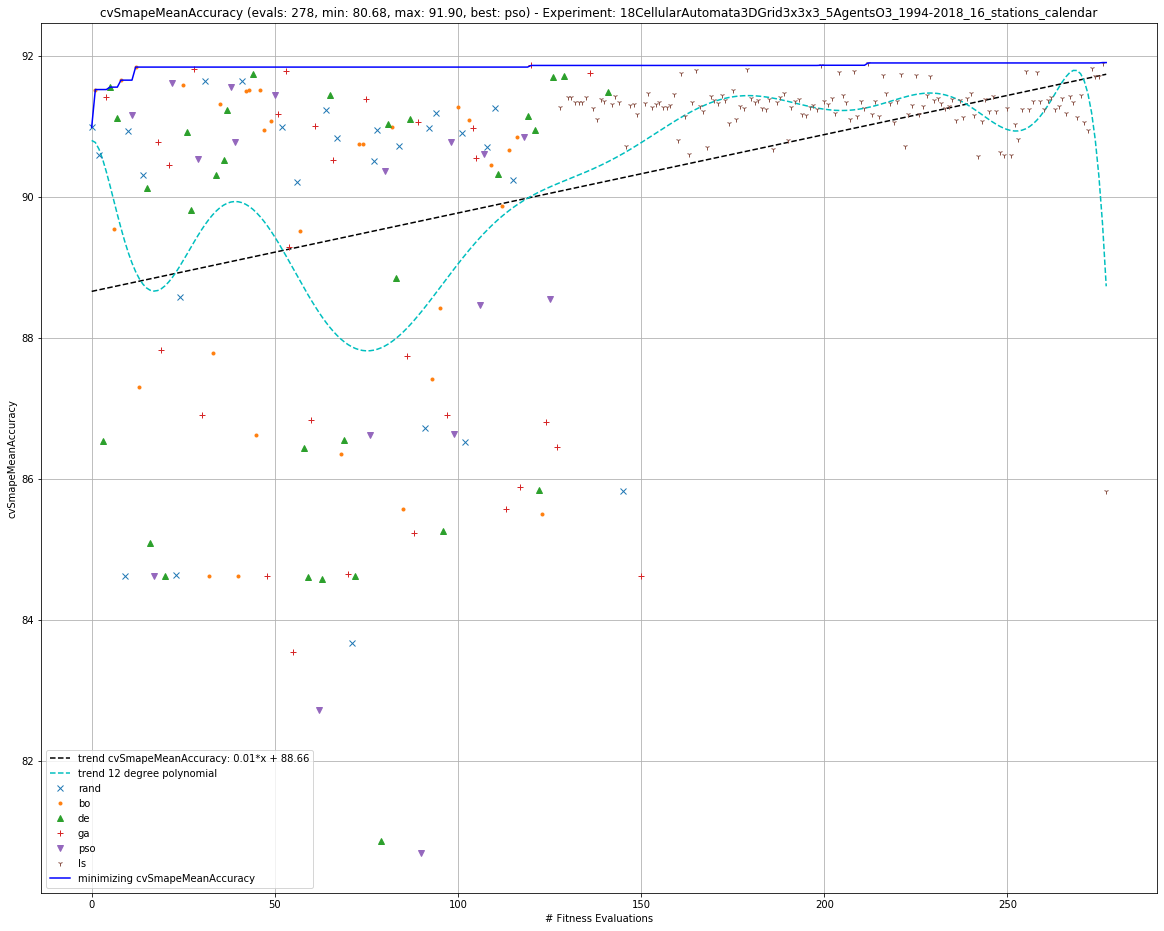

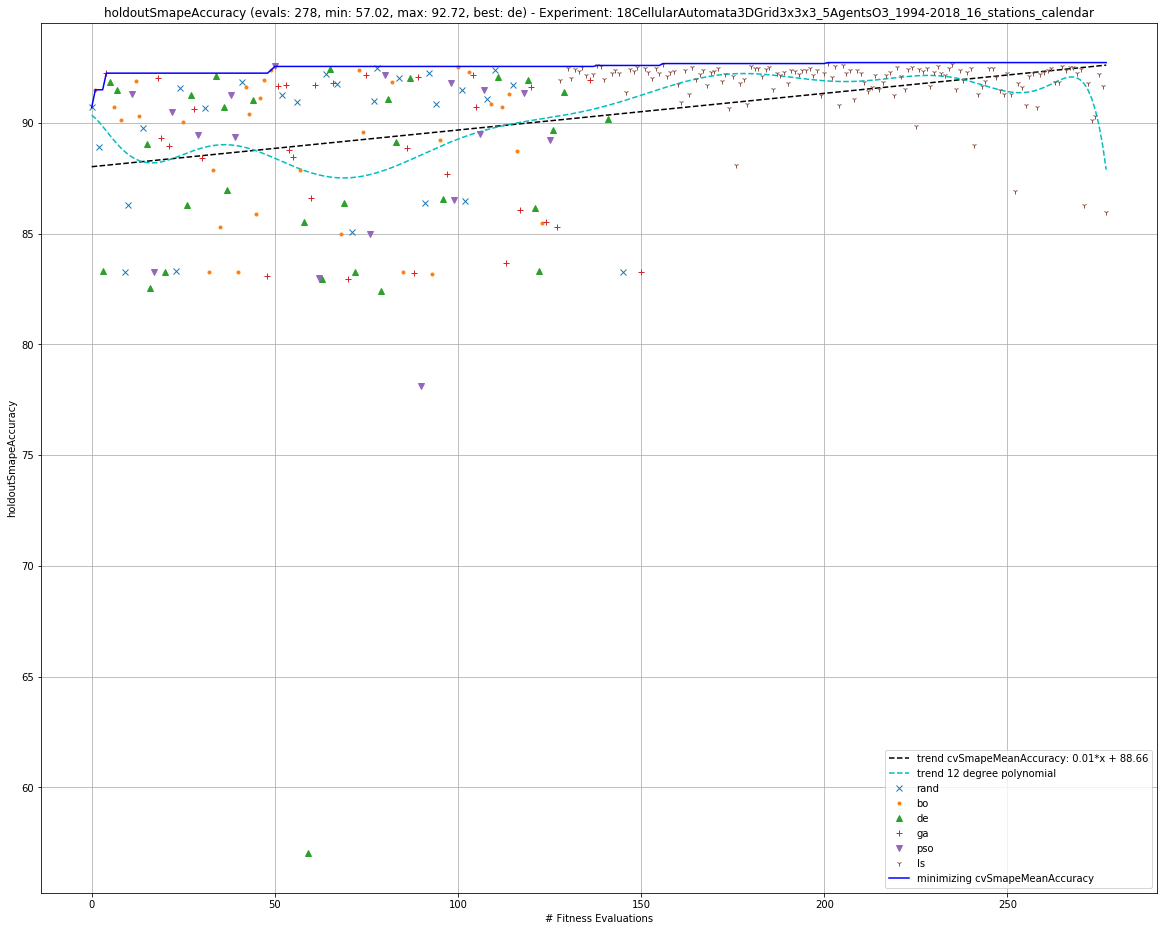

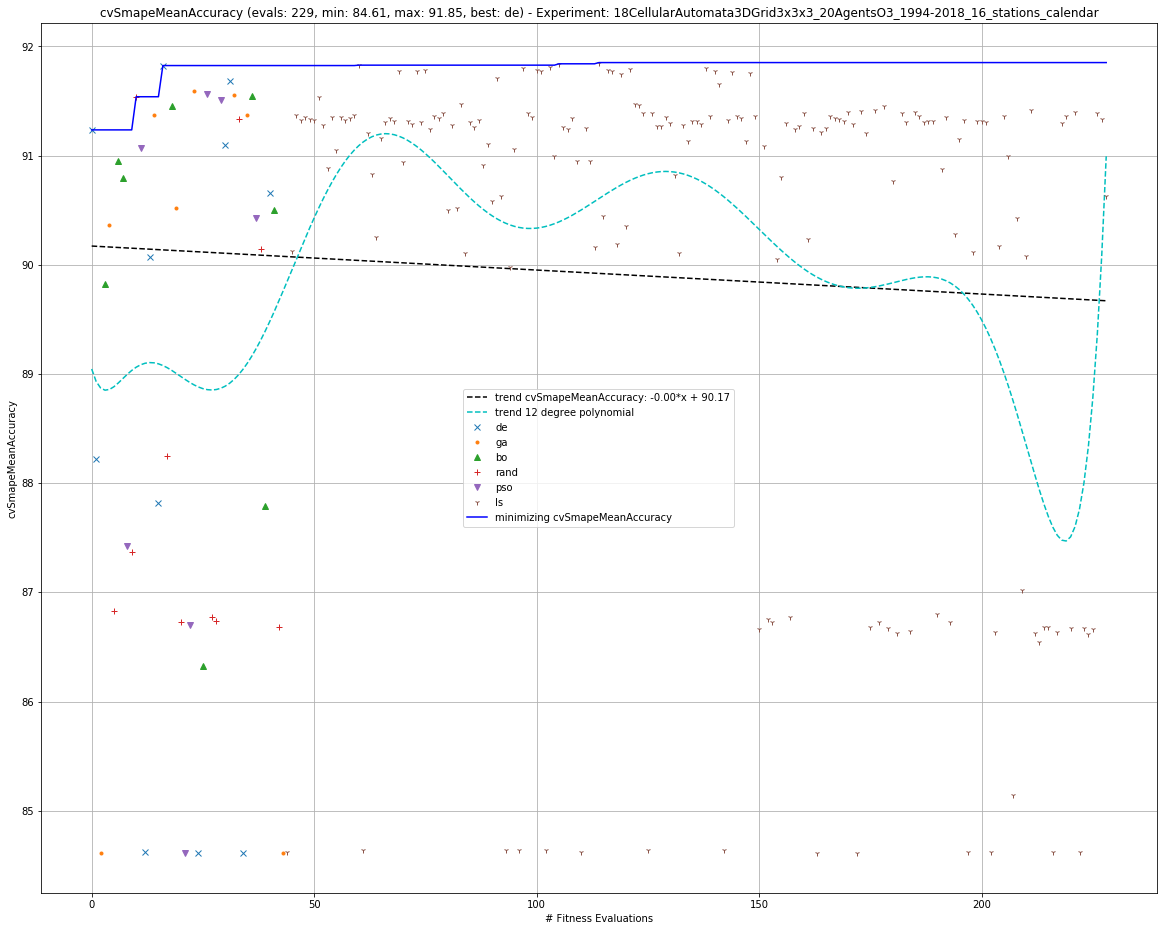

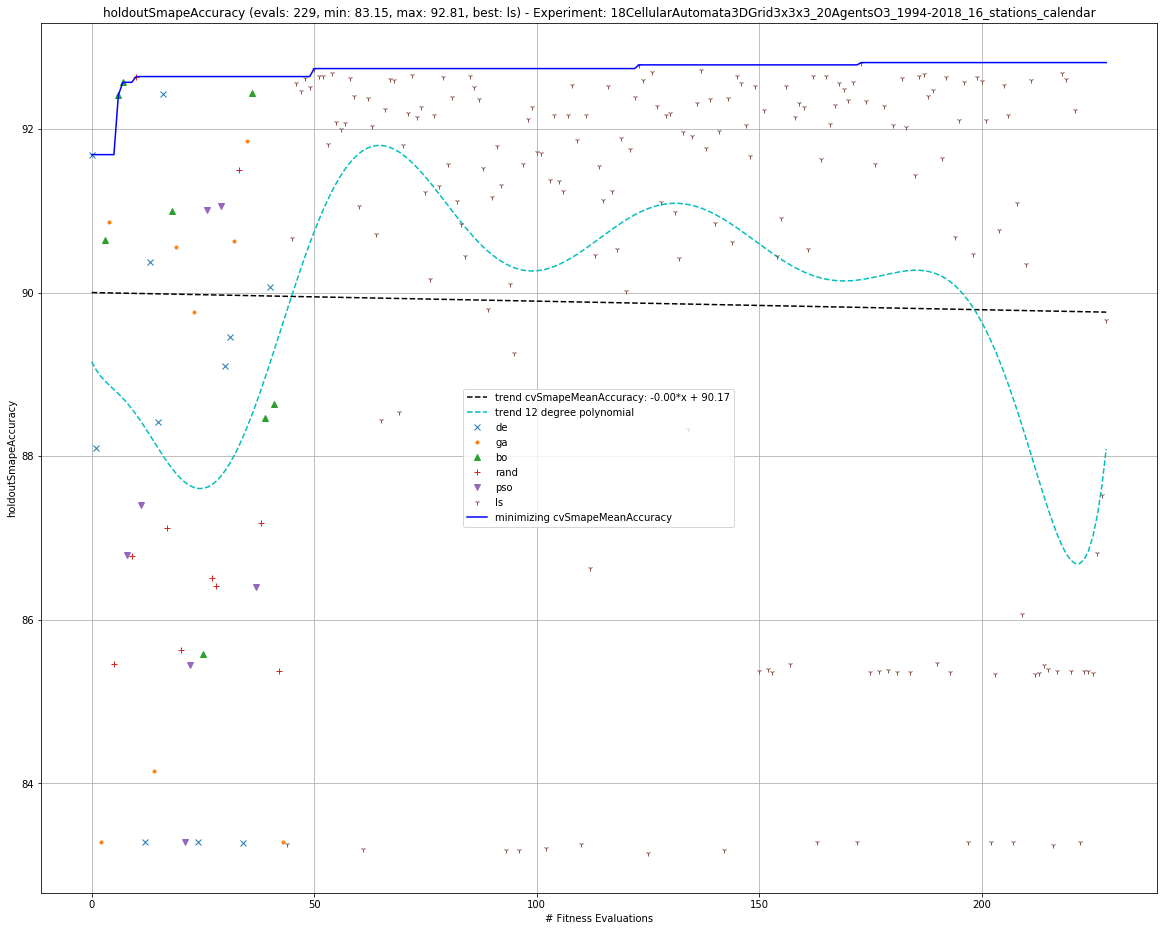

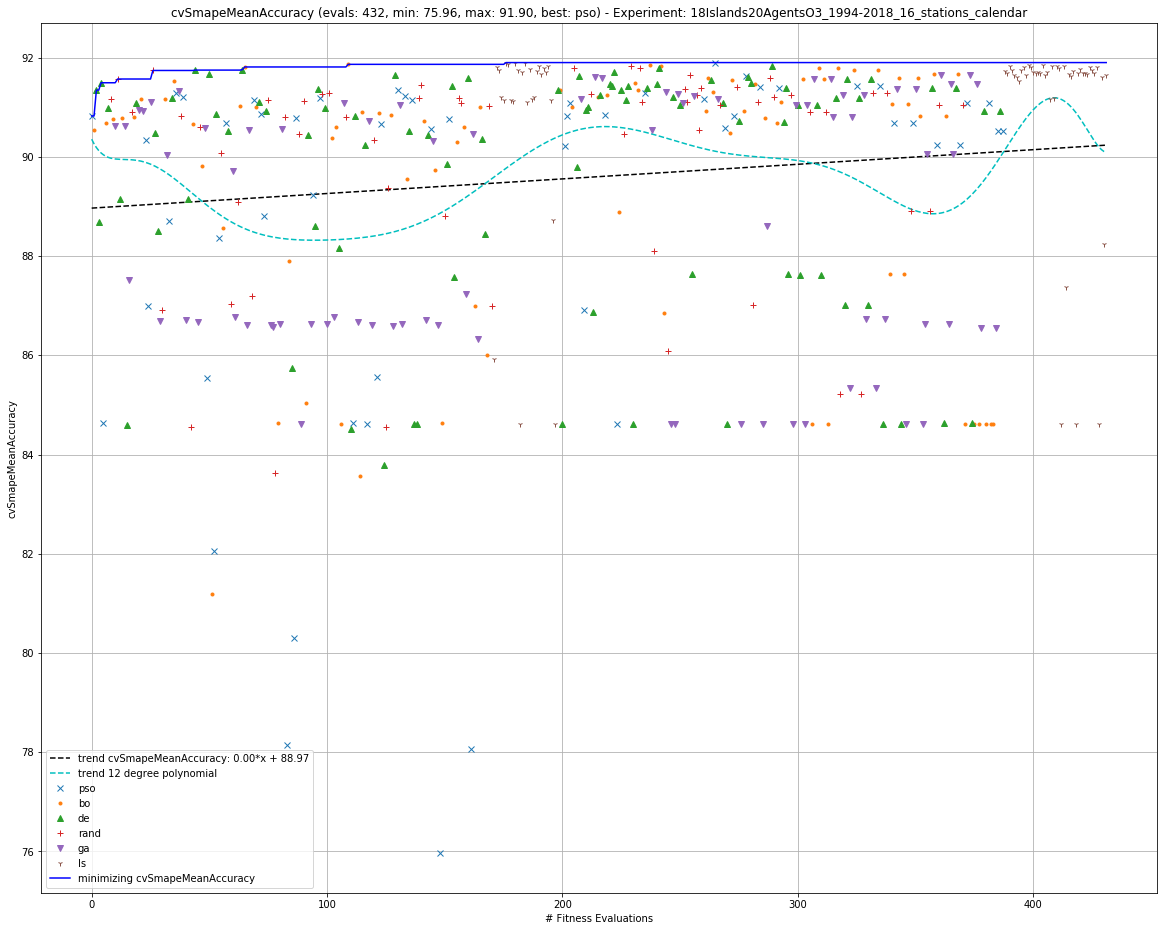

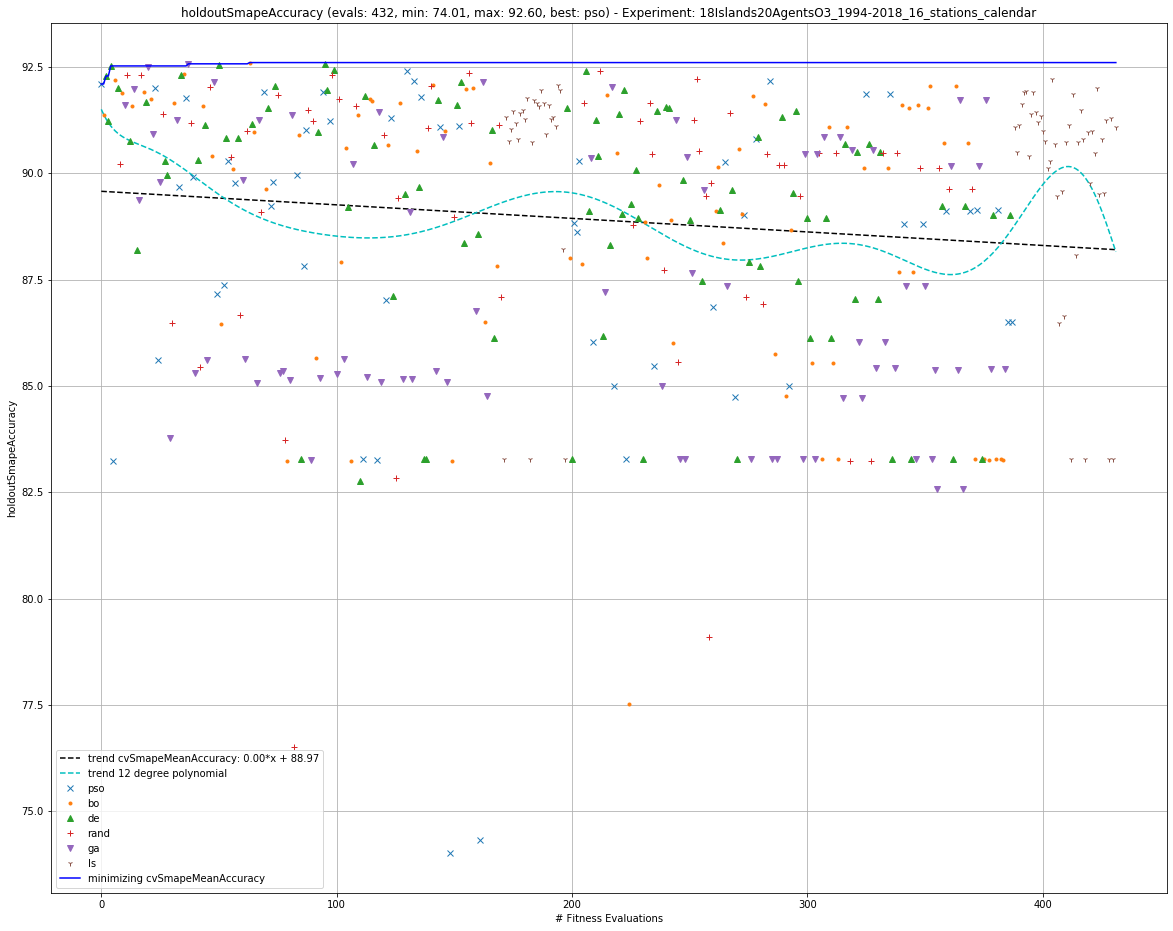

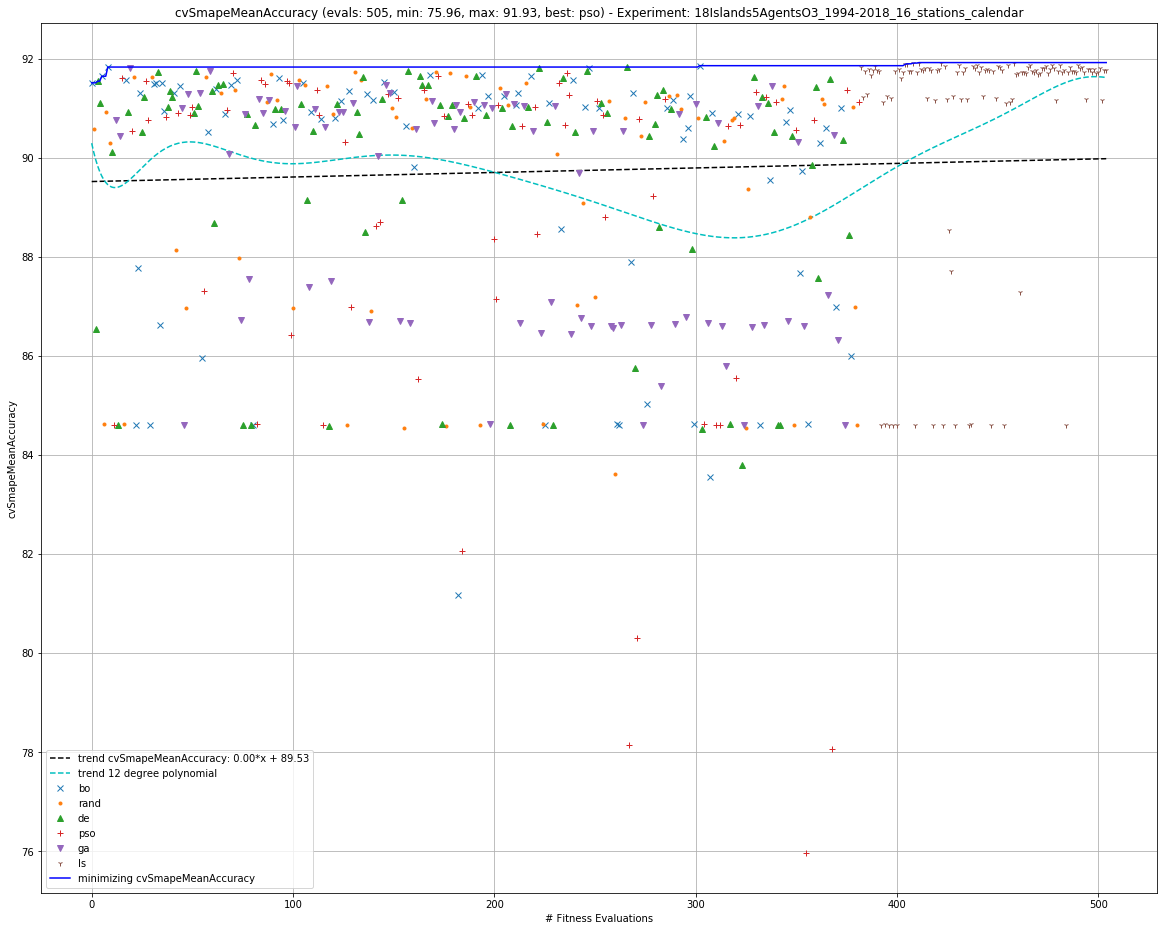

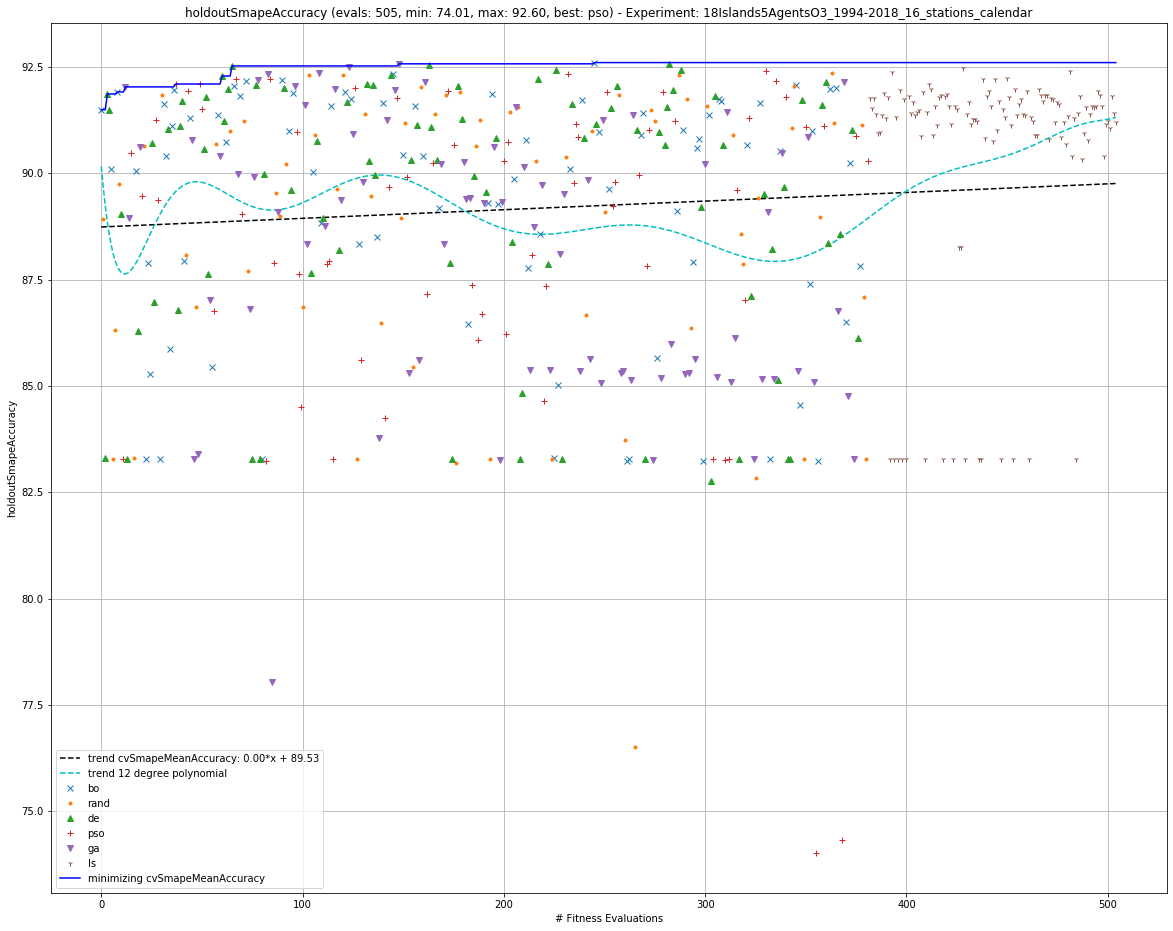

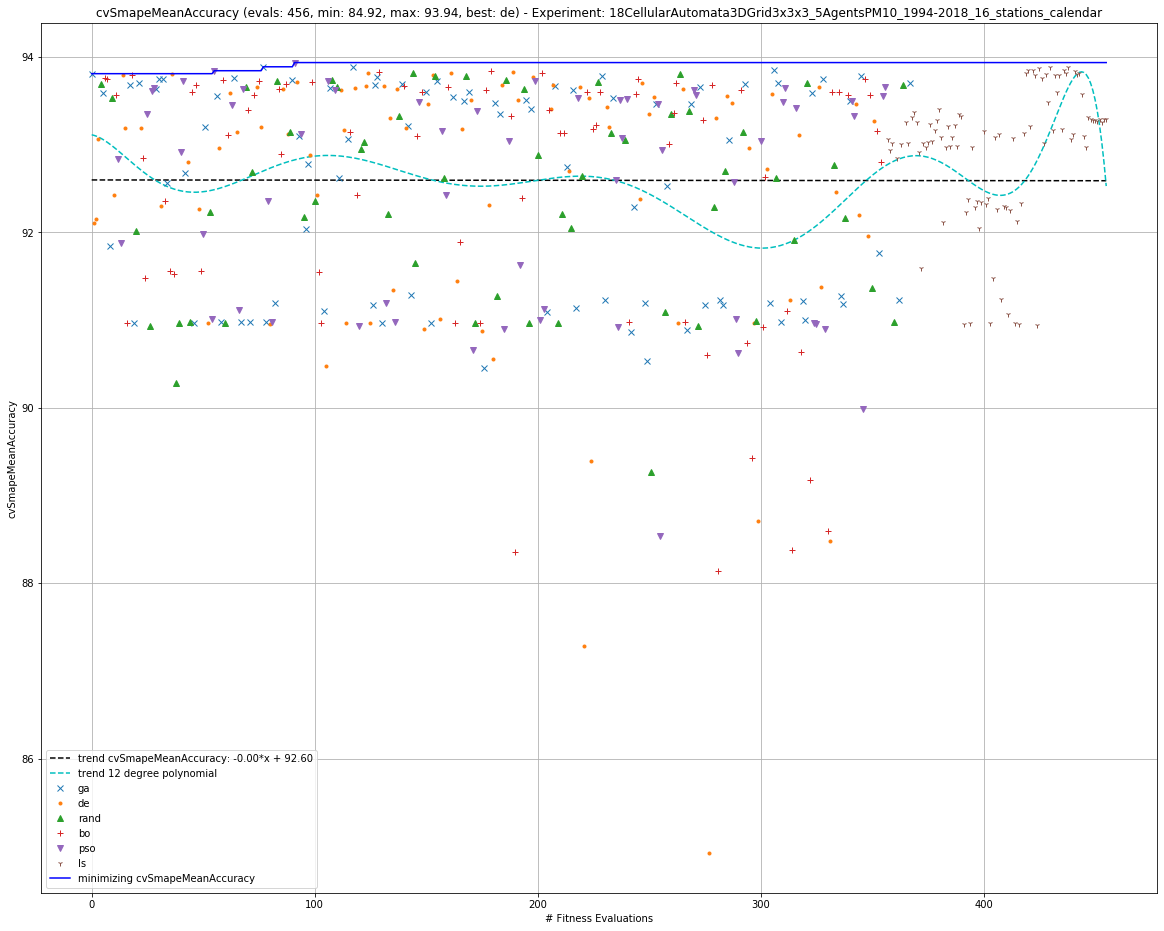

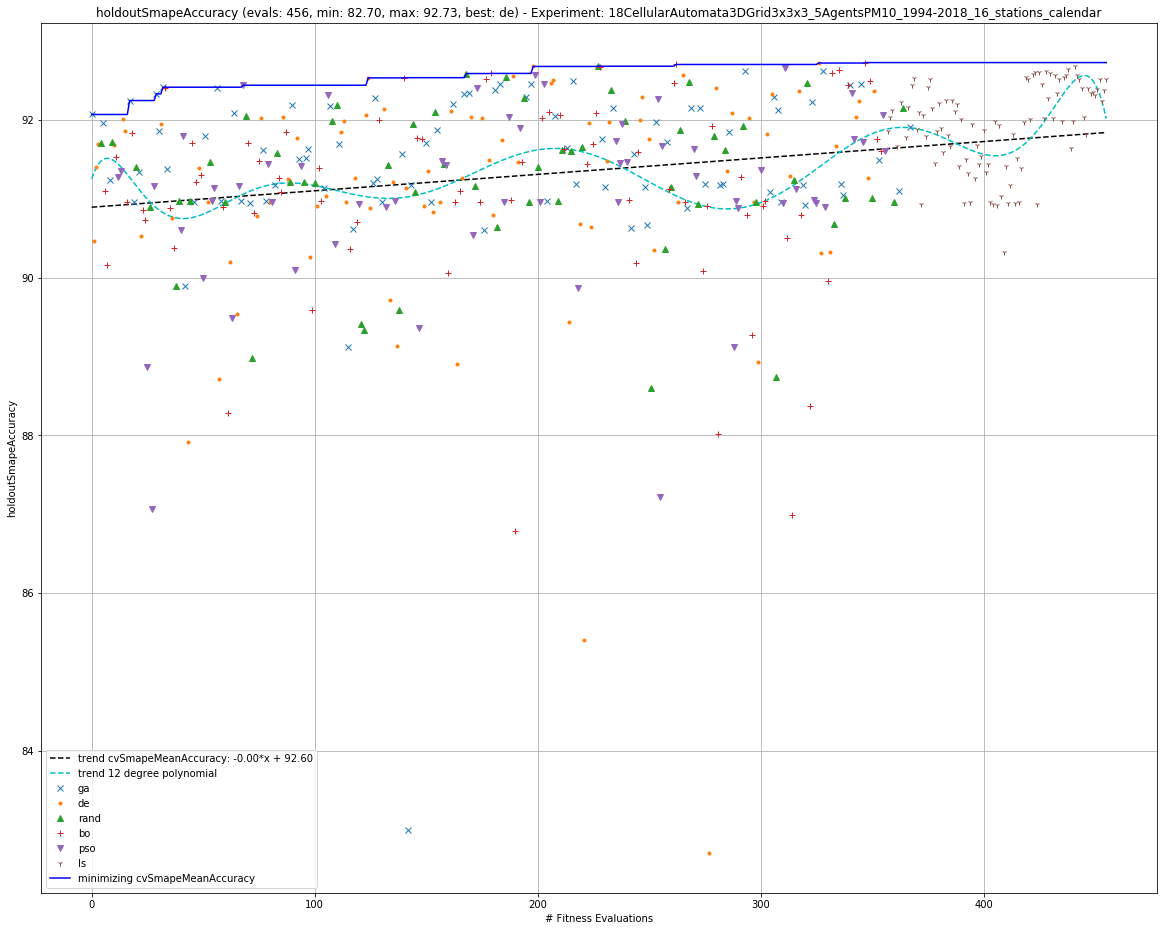

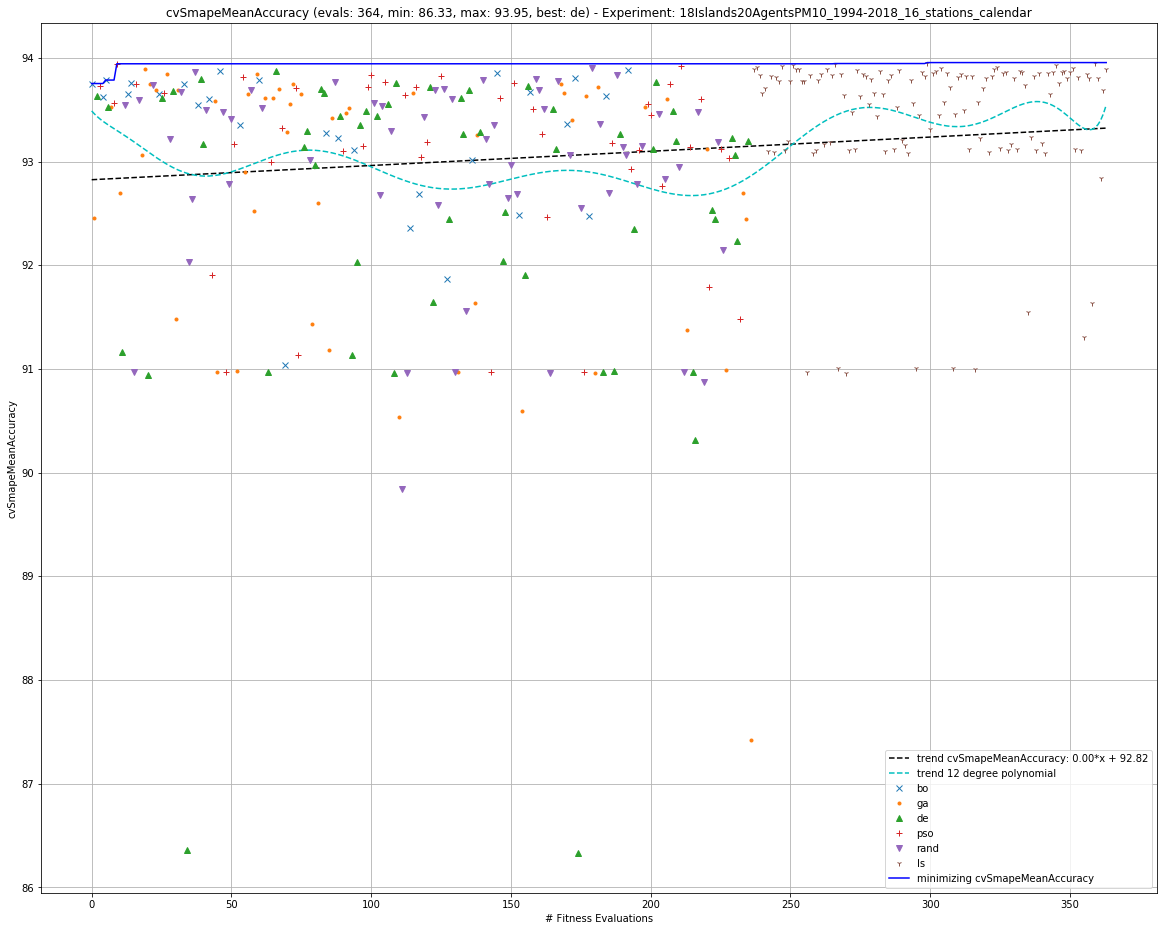

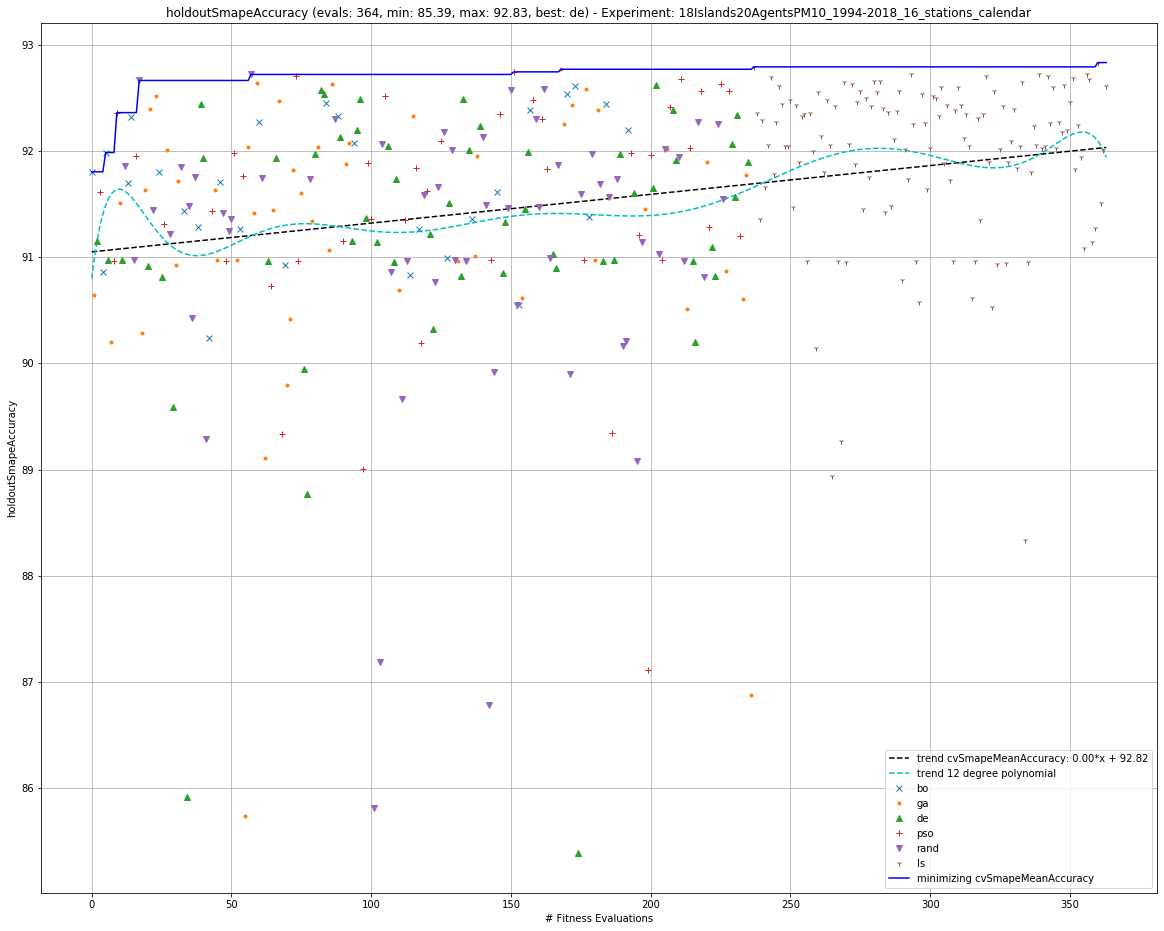

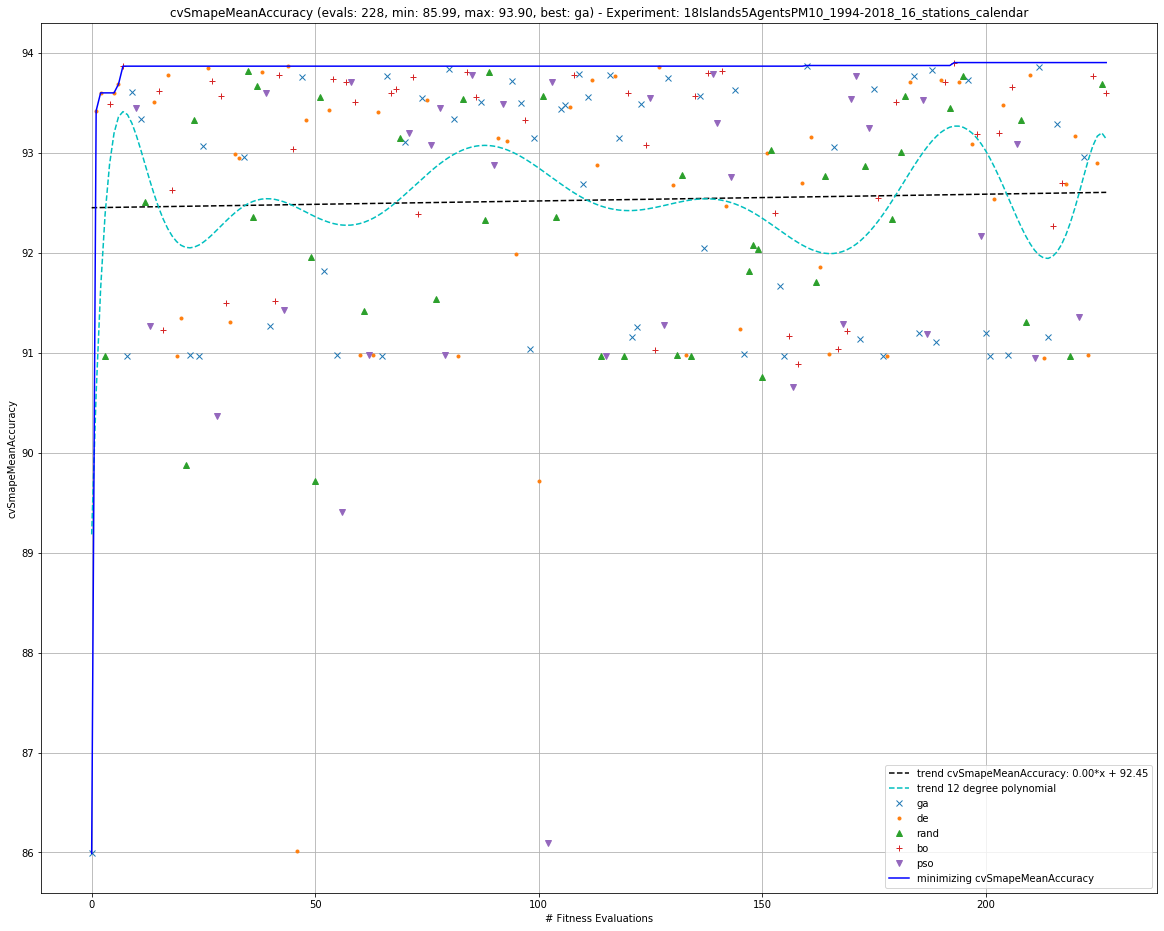

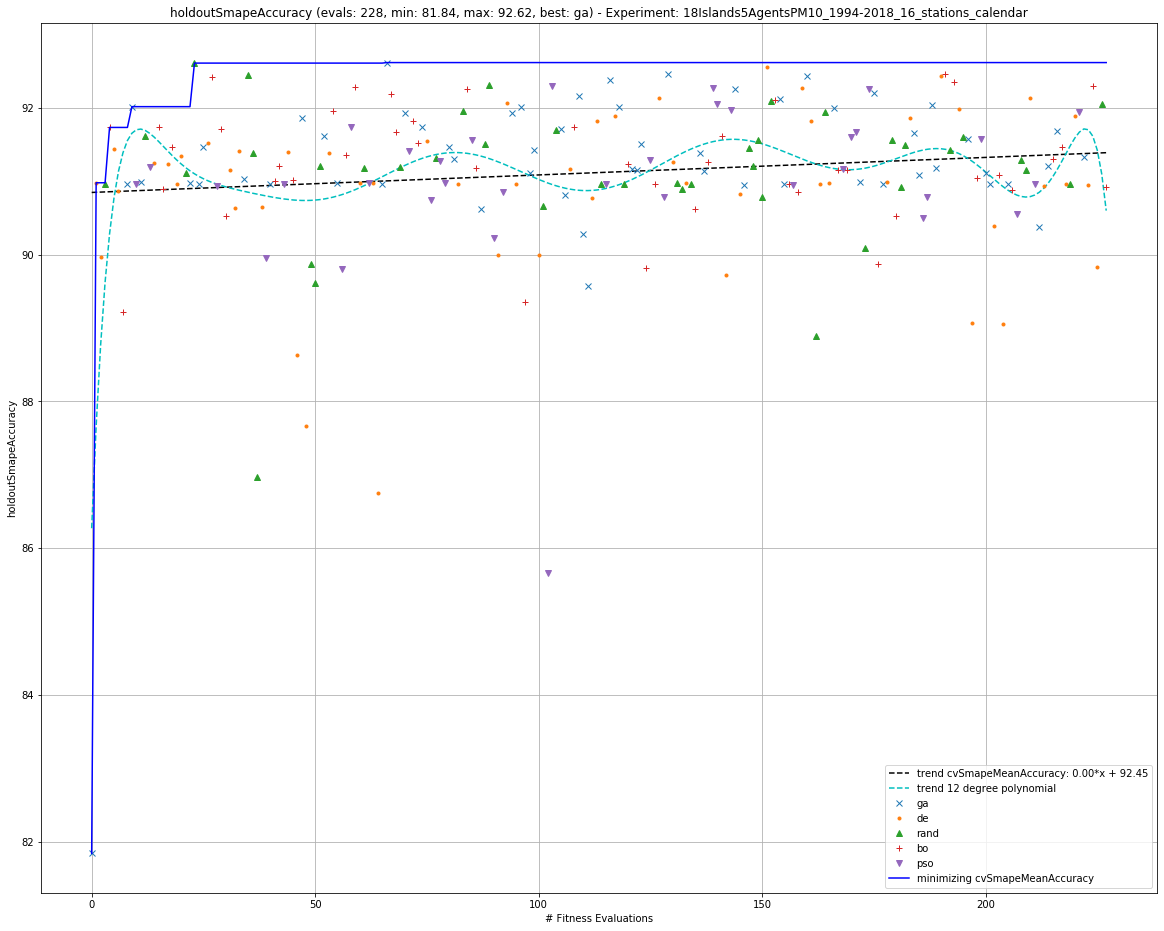

In [69]:
import numpy as np
import matplotlib.pyplot as plt

variables = [
    "cvSmapeMeanAccuracy", 
#     "holdoutMse",
    "holdoutSmapeAccuracy"
]
figure_size = [20, 16]
remove_outliers = False
outlier_std = 3
minimizing = False

def getMinimizingMaximizingArray(k, minimizing=True):
    minsArray = []
    minValue = k[0]
    for value in np.array(k):
        if minimizing:
            if value < minValue:
                minValue = value
        else:
            if value > minValue:
                minValue = value
        minsArray.append(minValue)    
    return np.array(minsArray)
    
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

for current_experiment in experiment_directories:
    
    legends = []
    for variable in variables:    
       
        df2 = df.loc[df["experiment"] == current_experiment]
        
#         df2 = df2.loc[df2["optimizer"] != "ls"]
        
        df2 = df2.drop_duplicates()
        df2.sort_index(inplace=True)
    
        if remove_outliers:
            df2 = df2[~(np.abs(df2[variable] - df2[variable].mean()) > (outlier_std * df2[variable].std()))]
    
        dict_points = {}        
        for optimizer in df2["optimizer"].unique():
            dict_points[optimizer + "_y"] = []
            dict_points[optimizer + "_x"] = []
        i = 0
        for index, row in df2.iterrows():
            optimizer = row["optimizer"]
            dict_points[optimizer + "_y"].append(row[variable])
            dict_points[optimizer + "_x"].append(i)            
            i += 1
    
        x = np.array(range(0, len(df2[variable])))
        y = df2[variable].values 
        
        fig, ax = plt.subplots(1, 1, figsize=figure_size)
        ax.set_ylabel(variable)
        ax.set_xlabel('# Fitness Evaluations')

        # Linear regression trend
        z = np.polyfit(x, y, 1) 
        trendpoly1d = np.poly1d(z)
        ax.plot(x, trendpoly1d(x) , 'k--')
        legends.append("trend " + variable + ": {:.2f}*x + {:.2f}".format(z[0], z[1]))
        
        z2 = np.polyfit(x, y, 12) 
        trendpoly2d = np.poly1d(z2)
        ax.plot(x, trendpoly2d(x) , 'c--')
        legends.append("trend 12 degree polynomial")
                
        # Scatter plot all data points based on method    
        i = 0
        styles = ["x", ".", "^", "+", "v", "1", "*"]
        for optimizer in df2["optimizer"].unique():
            ax.plot(dict_points[optimizer + "_x"], dict_points[optimizer + "_y"], styles[i]);
            legends.append(optimizer)
            i += 1

        ax.plot(x, getMinimizingMaximizingArray(df2[variable].values, minimizing), "b-");
        legends.append("minimizing " + variable)
        
        ax.legend(legends)
        best_method = df2["optimizer"].loc[df2[variable].idxmin()]
        ax.set_title('{} (evals: {}, min: {:.2f}, max: {:.2f}, best: {}) - Experiment: {}'.format(variable, len(df2[variable]), min(df2[variable]), max(df2[variable]), best_method, current_experiment))
        ax.grid(True) 
    
#         break
#     break